In [1]:
pacman::p_load(ggplot2,ggpubr,phylotools,geiger,ggtreeExtra,data.table,
               phytools,phyloseq,ggtree,ape,grid,tidyr,wesanderson,weights,
               ggnewscale,stringr,lubridate,ggridges,patchwork,ggstance,dendextend,tidyverse)

In [2]:
sam_with_meta_bact <- data.frame(fread(file.path("..","..","data","sam_with_meta_bact.csv")))
sam_with_meta <- data.frame(fread(file.path("..","..","data","sam_with_meta_euk.csv")))
data_tree_bact <- data.frame(fread(file.path("..","..","data","data_tree_bact.csv")))
data_tree_euk <- data.frame(fread(file.path("..","..","data","data_tree_euk.csv")))

In [3]:
sam_with_meta_bact_filt <- data.frame(fread(file.path("..","..","data","sam_with_meta_bact_filt.csv")))
sam_with_meta_filt <- data.frame(fread(file.path("..","..","data","sam_with_meta_euk_filt.csv")))

In [4]:
mag_abund_frame = data.frame(fread("../../data/mag_abund_res_90perc_top20.csv"))
metadata_file = read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                                   "meta-lakes/meta-lakes-pipeline/data/all_metadata_12May.csv"))
metadata_file["SampleDate"] = "1900-01-01"
for (curr in 1:nrow(metadata_file)) {
    curr_token = metadata_file$Analysis.Project.Analysis.Project.Name[curr]

    if (grepl("ME", curr_token)) {
        listed_meta = unlist(strsplit(curr_token, "-ME"))
        curr_token = unlist(strsplit(listed_meta[length(listed_meta)], "-"))[1]
        sample_date = curr_token
    }
    if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
        listed_meta = unlist(strsplit(curr_token, "D"))
        sample_date = listed_meta[1]
        curr_token = sample_date
        if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {

            listed_meta = unlist(strsplit(curr_token, "s"))
            sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
        } 
    } else if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {
        listed_meta = unlist(strsplit(curr_token, "s"))
        sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
    } else if (!is.na(curr_token)) {
        listed_meta = unlist(strsplit(curr_token, "-"))
        sample_date = trimws(unlist(strsplit(listed_meta[1], "deep"))[1])
    } else {
        sample_date = ""
    }

    if (grepl("Fre",sample_date)) {
        sample_date = "Control"
    }
    if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
        sample_date = unlist(strsplit(sample_date,"D"))[1]

        if (grepl("s", tolower(sample_date)) & !grepl("sep", tolower(sample_date))) {

            sample_date = unlist(strsplit(sample_date, "s"))[1]
        }
        metadata_file$SampleDate[curr] = sample_date
    } else {
        metadata_file$SampleDate[curr] = sample_date
    }


}
mag_abund_frame = mag_abund_frame %>%
    dplyr::left_join(metadata_file)
spiny_abund_frame = data.frame(fread("../../data/spiny_mag_abund_res_90perc.csv")) %>%
    dplyr::left_join(metadata_file)

Joining with
`by =
join_by(SeqProjID)`
Joining with
`by =
join_by(SeqProjID)`


Warning message:
“Removed 6 rows
containing
missing values
(`geom_point()`).”


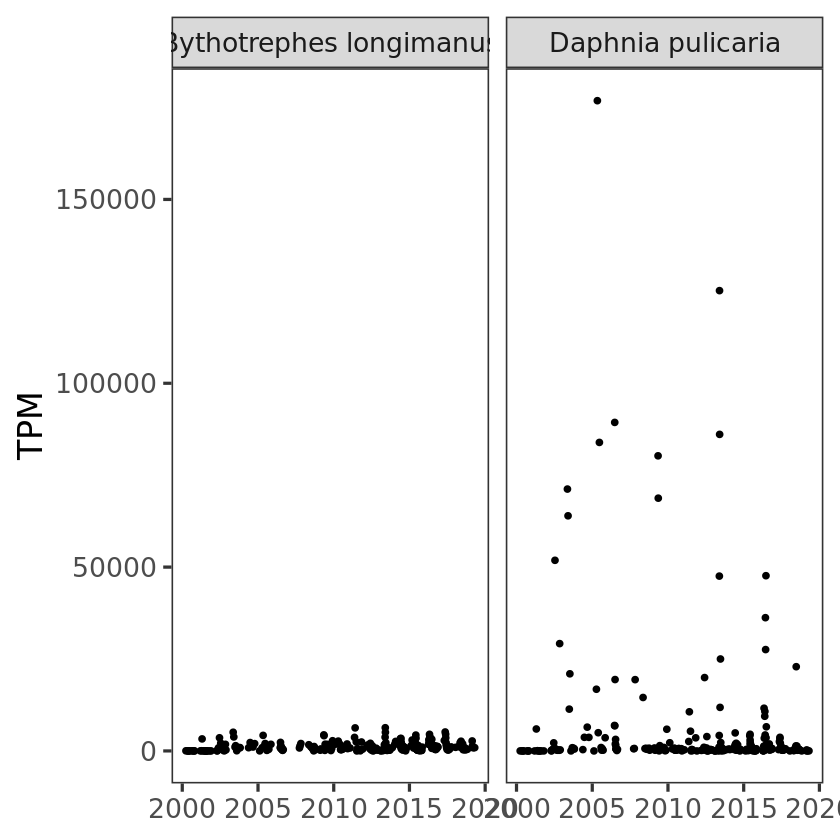

In [5]:
ggplot(spiny_abund_frame %>%
       dplyr::mutate(MAGName = dplyr::case_when(grepl("KMAS001",MAG) ~ "Daphnia pulicaria",
                                                grepl("KMAS002",MAG) ~ "Bythotrephes longimanus"))) + 
        geom_point(aes(x = as.Date(SampleDate,format="%d%b%Y"),
                                           y = TPM)) + facet_wrap(~MAGName) + theme_test(base_size=20) +
        theme(axis.title.x=element_blank())

In [6]:
## information on when the climatological seasons occur
seasonal_info=read.csv("../../data/season_dates.csv",comment="#") %>%
    dplyr::mutate(StartDate=as.Date(StartDate,origin="1970-01-01",format="%Y-%m-%d"),
                  EndDate=as.Date(EndDate,origin="1970-01-01",format="%Y-%m-%d"))
get_season_from_date <- function(date_vect) {
    season_list = c()
    for (date_curr in date_vect) {
        selected_season = seasonal_info %>% dplyr::filter((StartDate <= date_curr)&(EndDate >= date_curr))
        if (length(selected_season)==0) {
            season_list = c(season_list,"Missing")
        } else {
            if (length(selected_season$Season) > 1) {
                print("YO what gives")
                print(selected_season$Season)
            }
            season_list = c(season_list,as.character(selected_season$Season))
        }
    }
    return(season_list)
}

for_plotting = sam_with_meta %>% dplyr::inner_join(data_tree_euk, by = c("X.rname" = "label","Label"))

for (row_curr in c(1:nrow(for_plotting))) {
    if (trimws(for_plotting$Phylum[row_curr]) == "Metazoa") {
        extra_slots = unlist(strsplit(for_plotting$AllOthers[row_curr],";"))
        if (length(extra_slots) == 11) {
            for_plotting$Phylum[row_curr] = trimws(extra_slots[1])
            for_plotting$Class[row_curr] = trimws(extra_slots[5])
            for_plotting$Order[row_curr] = trimws(extra_slots[9])
            for_plotting$Family[row_curr] = trimws(extra_slots[10])
            for_plotting$Genus[row_curr] = trimws(extra_slots[11])
        } else if (length(extra_slots == 7)) {
            for_plotting$Phylum[row_curr] = trimws(extra_slots[1])
            for_plotting$Class[row_curr] = trimws(extra_slots[3])
            for_plotting$Order[row_curr] = trimws(extra_slots[5])
            for_plotting$Family[row_curr] = trimws(extra_slots[6])
            for_plotting$Genus[row_curr] = trimws(extra_slots[7])
        }
        print(for_plotting[row_curr,])
    }
    if (trimws(for_plotting$Phylum[row_curr]) == "Opisthokonta") {
            for_plotting$Phylum[row_curr] = "Choanozoa"
            for_plotting$Class[row_curr] = "Ichthyosporea"
            for_plotting$Order[row_curr] = "Eccrinida"
            for_plotting$Family[row_curr] = "Piridae"
            for_plotting$Genus[row_curr] = "Pirum"
    }
    
    if (trimws(for_plotting$Phylum[row_curr]) == "Cryptophyceae") {
        for_plotting$Genus[row_curr] = for_plotting$Family[row_curr]
        for_plotting$Family[row_curr] = for_plotting$Order[row_curr]
        for_plotting$Order[row_curr] = for_plotting$Class[row_curr]
        for_plotting$Class[row_curr] = for_plotting$Phylum[row_curr]
        for_plotting$Phylum[row_curr] = "Cryptophyta"
    }
    
    if (trimws(for_plotting$Order[row_curr]) == "Fragilariophyceae") {
            for_plotting$Class[row_curr] = for_plotting$Order[row_curr]
            for_plotting$Order[row_curr] = for_plotting$Species[row_curr]
            for_plotting$Family[row_curr] = ""
            for_plotting$Genus[row_curr] = ""
            for_plotting$Species[row_curr] = ""
    } else if (trimws(for_plotting$Class[row_curr]) == "Bacillariophyta") {
            for_plotting$Class[row_curr] = for_plotting$Order[row_curr]
            for_plotting$Order[row_curr] = for_plotting$Species[row_curr]
            for_plotting$Family[row_curr] = ""
            for_plotting$Genus[row_curr] = ""
            for_plotting$Species[row_curr] = ""
    }
}
curr_cm="RF01960"

means_within_seasons = for_plotting %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))) %>%
    dplyr::select(-Phylum,-Genus,-Family,-Class,-Order,-Species,-Domain) %>%
    dplyr::left_join(read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos",
                                        "2021-mendota-18S","refseq-DIAMOND", 
                                        "tree-builder", "2021-12-20_eukaryota", paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),by=c("X.rname"="qseqid")) %>%
    dplyr::mutate(Order = dplyr::case_when(Order == "Coscinodiscophycidae" ~ "Aulacoseirales",
                                           TRUE ~ Order)) %>%
    dplyr::mutate(FormattedDate=as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")) %>%
    dplyr::full_join(seasonal_info,by=c("Year")) %>%
    dplyr::filter((FormattedDate >= StartDate) & (FormattedDate <= EndDate))

for_plotting_old_zscore = for_plotting %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))) %>%
    dplyr::select(-Phylum,-Genus,-Family,-Class,-Order,-Species,-Domain) %>%
    dplyr::left_join(read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos",
                                        "2021-mendota-18S","refseq-DIAMOND", 
                                        "tree-builder", "2021-12-20_eukaryota", paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),by=c("X.rname"="qseqid")) %>%
    dplyr::mutate(Order = dplyr::case_when(Order == "Coscinodiscophycidae" ~ "Aulacoseirales",
                                           TRUE ~ Order))%>% 
    dplyr::group_by(Label) %>%
    dplyr::mutate(ZScore = (TPM - mean(TPM)) / sd(TPM)) %>%
    dplyr::ungroup()

total_in_season = means_within_seasons %>% 
    dplyr::distinct(Season,Year,FormattedDate) %>%
    dplyr::group_by(Season,Year) %>%
    dplyr::tally()

means_with_seasons_ = means_within_seasons %>% 
    dplyr::left_join(total_in_season) %>%
    dplyr::mutate(Weights = 1 / n) %>%
    dplyr::group_by(Season,Label) %>%
    dplyr::summarize(meanTPM = sum(TPM*Weights) / sum(Weights),
                     sdTPM = sqrt((sum(((TPM-sum(TPM*Weights) / sum(Weights))^2)*Weights) / 
                          (sum(Weights)*(length(Weights)-1)/length(Weights)))))

curr_cm="RF01960"
for_plotting = for_plotting %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))) %>%
    dplyr::select(-Phylum,-Genus,-Family,-Class,-Order,-Species,-Domain) %>%
    dplyr::left_join(read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos",
                                        "2021-mendota-18S","refseq-DIAMOND", 
                                        "tree-builder", "2021-12-20_eukaryota", paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),by=c("X.rname"="qseqid")) %>%
    dplyr::mutate(Order = dplyr::case_when(Order == "Coscinodiscophycidae" ~ "Aulacoseirales",
                                           TRUE ~ Order))%>%
    dplyr::full_join(seasonal_info,by=c("Year")) %>%
    dplyr::left_join(total_in_season) %>%
    dplyr::mutate(Weights = 1 / n) %>%
    dplyr::mutate(FormattedDate=as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))%>%
    dplyr::filter((FormattedDate >= StartDate) & (FormattedDate <= EndDate)) %>%
    dplyr::left_join(means_with_seasons_,by=c("Season","Label")) %>%
    dplyr::group_by(Label) %>%
    dplyr::mutate(ZScore = (TPM - meanTPM) / sdTPM) %>%
    dplyr::ungroup() %>% dplyr::select(-V1.x,-V1.y,-Superfamily.x,-Superfamily.y) %>%
    dplyr::filter(type.x=="S")

Warning message in dplyr::full_join(., seasonal_info, by = c("Year")):
“Detected an
unexpected
many-to-many
relationship
between `x` and
`y`.
ℹ Row 1 of `x`
  matches
  multiple rows
  in `y`.
ℹ Row 90 of `y`
  matches
  multiple rows
  in `x`.
ℹ If a
  many-to-many
  relationship
  is expected,
  set
  `relationship
  =
  "many-to-many"`
  to silence
  this warning.”
Joining with
`by =
join_by(Year,
Season)`
`summarise()`
has grouped
output by
'Season'. You
can override
using the
`.groups`
argument.
Warning message in dplyr::full_join(., seasonal_info, by = c("Year")):
“Detected an
unexpected
many-to-many
relationship
between `x` and
`y`.
ℹ Row 1 of `x`
  matches
  multiple rows
  in `y`.
ℹ Row 90 of `y`
  matches
  multiple rows
  in `x`.
ℹ If a
  many-to-many
  relationship
  is expected,
  set
  `relationship
  =
  "many-to-many"`
  to silence
  this warning.”
Joining with
`by =
join_by(Year,
Season)`


In [24]:
unique(for_plotting$Season)

[1] "Spring"      "LateSummer"  "EarlySummer" "Ice"         "Fall"       
[6] "Clearwater"

In [7]:

make_euk_tree <- function(input_tree_file,input_tree_dict,cluster_all,chosen_layout="circular") {
  tree_file <- as.phylo(ggtree(input_tree_file,layout=chosen_layout))
  tree_plot <- as.data.frame(tree_file %>% fortify() %>%
                                   as_tibble()) 
  tree_plot <- tree_plot %>% dplyr::left_join(input_tree_dict,by=c("label"="Labels"))%>% 
        dplyr::left_join(cluster_all, by = c("qseqid" = "query")) %>%
        dplyr::filter((type == "S") | (is.na(type)))
  
  unique_phyla = unique(input_tree_dict$Phylum)
  unique_phyla = unique_phyla[unique_phyla != ""]
  # change this line
  tip_colors <- lapply(unique_phyla, function(x)
  {tree_plot$label[grepl(paste(x, collapse="|"),
                             tree_plot$Phylum)]})
  names(tip_colors) <- unique_phyla
  tip_colors <- Filter(function(x) length(x) > 0, tip_colors)
  #tree_file_to_plot <- as(tree_plot,"phylo") 
  for_input = drop.tip(ape::root(as.phylo(ggtree(tree_plot)), node = 86),
                tip=extract.clade(alveolate_tree,node=107)$tip.label[-1],subtree=FALSE)
  tree_to_plot <- groupOTU(for_input, tip_colors,
                              overlap="overwrite")
                       
  data_tree <- as.data.frame(ggtree(tree_to_plot)$data) %>%
        dplyr::left_join(input_tree_dict,by=c("label"="Labels"))%>% 
        dplyr::left_join(cluster_all, by = c("qseqid" = "query")) %>%
        dplyr::filter((type == "S") | (is.na(type)))
  data_tree = data_tree %>%
      dplyr::mutate(Metagenome = dplyr::case_when(grepl("rRNA",label) ~ "MG",
                                                  TRUE ~ "Ref")) %>%
      dplyr::mutate(Label = dplyr::case_when(Label == Label ~ Label,
                                      TRUE ~ "Ref"),
                    type = dplyr::case_when(Metagenome != "Ref" ~ type,
                                      TRUE ~ "S")) %>%
      dplyr::filter(type == "S")
  data_tree = data_tree %>%
    #dplyr::left_join(input_tree_dict,by=c("label"="Labels")) %>%
    dplyr::mutate(Metagenome = 
                    dplyr::case_when(Metagenome  == "Ref" ~ "Ref",
                                     Metagenome == "MG" ~ "MG",
                                     TRUE ~ "None"))
  return(data_tree)
}


In [8]:
tax_table = read.csv(file.path("/vortexfs1/omics/alexander/akrinos/2021-mendota-18S",
                   "MendotaMAGs/eukulele-snake/marmmetspplusjgi/taxonomy-table.txt"), sep="\t")
metazoan_tree = read.tree(file.path("/vortexfs1/omics/alexander/akrinos/2021-mendota-18S",
                           "refseq-DIAMOND/tree-builder/2021-12-27_metazoa/iqtree_select/total_tree_RF01960.treefile"
                                     ))
metazoan_tree = ape::root(as.phylo(ggtree(read.tree(file.path("/vortexfs1/omics/alexander/akrinos/2021-mendota-18S",
                           "refseq-DIAMOND/tree-builder/2021-12-27_metazoa",
                           "iqtree_select/total_tree_RF01960.treefile"))) + 
                            geom_text(aes(label=label))), node = 32)
metazoan_tree = drop.tip(metazoan_tree,tip=extract.clade(metazoan_tree,node=48)$tip.label[-1],subtree=FALSE)

new_mag_names = read.csv("/vortexfs1/omics/alexander/akrinos/2021-mendota-18S/new_mag_names.csv")
data_frame_metazoan <- as.data.frame(metazoan_tree %>% fortify() %>% as_tibble()) %>%
    dplyr::left_join(tax_table, by=c("label"="Source_ID")) %>%
    dplyr::mutate(label = vapply(strsplit(label,"\\."), `[`, 1, FUN.VALUE=character(1))) %>%
    dplyr::left_join(new_mag_names, by=c("label"="bin")) %>%
    dplyr::select(-Genus,-Family,-Class,-Order,-Species) %>%
    dplyr::left_join(read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos",
                                        "2021-mendota-18S","refseq-DIAMOND", 
                                        "tree-builder", "2021-12-27_metazoa",
                                        paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),by=c("label"="qseqid")) %>%
    dplyr::mutate(Type = dplyr::case_when(grepl("Ga",label) ~ "MG",
                                          grepl("k1",label) ~ "Mendota reference",
                                   TRUE ~ "NCBI reference")) %>%
    dplyr::mutate(NewLab = dplyr::case_when(Phylum == "Ochrophyta"~ "Outgroup",
                                   TRUE ~ Order))%>%
    dplyr::mutate(NewLabGenus = dplyr::case_when(Phylum == "Ochrophyta"~ "",
                                                 !is.na(Genus) ~ Genus,
                                   TRUE ~ ""))%>%
    dplyr::mutate(NewSize = dplyr::case_when(Phylum == "Ochrophyta"~ "Outgroup",
                                   TRUE ~ ""))

In [9]:
## get season
getOurSeason <- function(date) {
    if (is.na(date)) {
        return("")
    }
    if (grepl("D",date) & !grepl("Dec",date)) {
        date = unlist(strsplit(date,"D"))[1]
    }
    if (grepl("Mendota",date)) {
        return("")
    }
    d <- as.POSIXlt(date, format="%d%b%Y")
    
    curr_year = format(as.Date("16May2013",format="%d%b%Y"),"%Y")
    WS <- as.POSIXlt(paste0(as.character(curr_year),"-12-15"), format = "%Y-%m-%d") # Winter Solstice
    SE <- as.POSIXlt(paste0(as.character(curr_year),"-03-15"),  format = "%Y-%m-%d") # Spring Equinox
    SS <- as.POSIXlt(paste0(as.character(curr_year),"-06-15"),  format = "%Y-%m-%d") # Summer Solstice
    FE <- as.POSIXlt(paste0(as.character(curr_year),"-09-15"),  format = "%Y-%m-%d") # Fall Equinox


    if (((d$yday >= WS$yday) & (d$yday < SE$yday)) | (d$yday < SE$yday)) {
        return("Winter")
    } else if ((d$yday >= SE$yday) & (d$yday < SS$yday)) {
        return("Spring")
    } else if ((d$yday >= SS$yday) & (d$yday < FE$yday)) {
        return("Summer")
    } else {
        return("Fall")
    }
}

In [10]:
t_test_2010 <- function(for_plotting, label, test = "ks", alternative="greater", thres_year = 2010) {
    pre_2010 <- for_plotting %>% dplyr::filter(Label == label) %>%
        dplyr::filter(Year <= thres_year)
    post_2010 <- for_plotting %>% dplyr::filter(Label == label) %>%
        dplyr::filter(Year > thres_year)
    if (test == "ks") {
        return(ks.test(pre_2010$TPM, post_2010$TPM))
    } else if (test == "t") {
        # if greater, pre-2010 is greater than post-2010. if less, pre-2010 is less than post-2010.
        return(t.test(pre_2010$TPM, post_2010$TPM,alternative=alternative))
    }
}

t_test_2010 <- function(for_plotting, label, weights="none",weightsy="non",
                        test = "ks", alternative="greater", thres_year = 2010) {
    pre_2010 <- for_plotting %>% dplyr::filter(Label == label) %>%
        dplyr::filter(Year <= thres_year)
    post_2010 <- for_plotting %>% dplyr::filter(Label == label) %>%
        dplyr::filter(Year > thres_year)
    if (test == "ks") {
        return(ks.test(pre_2010$TPM, post_2010$TPM))
    } else if (test == "t") {
        if (weights=="none"){
            weights=rep(1,length(pre_2010$TPM))
            weightsy=rep(1,length(post_2010$TPM))
        } else {
            weights=pre_2010$Weights
            weightsy=post_2010$Weights
        }
        # if greater, pre-2010 is greater than post-2010. if less, pre-2010 is less than post-2010.
        return(wtd.t.test(pre_2010$TPM, post_2010$TPM,
                          weight=weights,weighty=weightsy,alternative=alternative))
    }
}

categorize_vals = data.frame()
for_plot_tax = for_plotting %>% dplyr::distinct(Phylum,Order,Class,Genus,Family,Label)
for (curr_ind in c(1:nrow(for_plot_tax))) {
    curr = for_plot_tax$Label[curr_ind]
    curr_pval = t_test_2010(for_plotting, curr, test = "t", alternative="less", thres_year = 2010)$coefficients["p.value"]
    if (curr_pval <= 0.05) {
        curr_df = data.frame("Label"=curr, "p-value"=curr_pval,"Phylum"=trimws(for_plot_tax$Phylum[curr_ind]),
                             "Order"=trimws(for_plot_tax$Order[curr_ind]),
                             "Class" = trimws(for_plot_tax$Class[curr_ind]),
                             "Genus" = trimws(for_plot_tax$Genus[curr_ind]),
                             "Family" = trimws(for_plot_tax$Family[curr_ind]),
                             "Verdict"="IncreasedPost2010")
    } else if (curr_pval >= 0.95) {
        curr_df = data.frame("Label"=curr, "p-value"=curr_pval,"Phylum"=trimws(for_plot_tax$Phylum[curr_ind]),
                             "Order"=trimws(for_plot_tax$Order[curr_ind]),
                             "Class" = trimws(for_plot_tax$Class[curr_ind]),
                             "Genus" = trimws(for_plot_tax$Genus[curr_ind]),
                             "Family" = trimws(for_plot_tax$Family[curr_ind]),
                             "Verdict"="DecreasedPost2010")
    } else {
        curr_df = data.frame("Label"=curr, "p-value"=curr_pval, "Phylum"=trimws(for_plot_tax$Phylum[curr_ind]),
                             "Order"=trimws(for_plot_tax$Order[curr_ind]),
                             "Class" = trimws(for_plot_tax$Class[curr_ind]),
                             "Genus" = trimws(for_plot_tax$Genus[curr_ind]),
                             "Family" = trimws(for_plot_tax$Family[curr_ind]),
                             "Verdict"="NoChange")
    }
    categorize_vals = categorize_vals %>% dplyr::bind_rows(curr_df)
}
categorize_vals$Verdict[p.adjust(categorize_vals$p.value, "BH") <= 0.05] = "IncreasedPost2010"
categorize_vals$Verdict[p.adjust(1-categorize_vals$p.value, "BH") <= 0.05] = "DecreasedPost2010"
categorize_vals$Verdict[(p.adjust(1-categorize_vals$p.value, "BH") > 0.05) &
                        (p.adjust(categorize_vals$p.value, "BH") > 0.05)] = "NoChange"

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x and y separately because they are of different lengths”
Warning message in wtd.t.test(pre_2010$TPM, post_2010$TPM, weight = weights, weighty = weightsy, :
“Treating data for x 

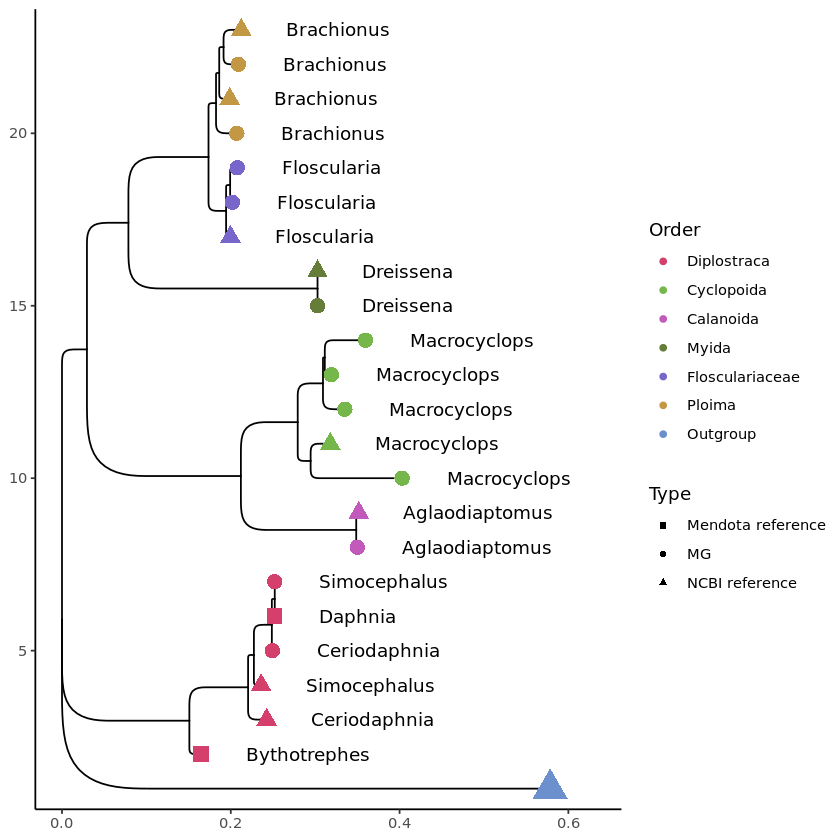

In [37]:
distinct_cols = c("#9f4764", "#58cb5f", "#be54c4", "#4fa433", "#7166d9", "#b0bf2e", "#8b57a1", 
                  "#92bc43", "#d24790", "#55bd81", "#d23d55", "#51c6c0", "#d24b29", "#60a2d7", 
                  "#de882f", "#6077c3", "#d0b13d", "#d08dce", "#417d23", "#e07f89", "#408147", 
                  "#e98060", "#338b70", "#a35630", "#77902d", "#d4a268", "#636f2d", "#9fb56c", 
                  "#86672d", "#9d8527", "black")
distinct_cols = c("#d4406b","#76b74b","#c25abc","#657d39","#7966ca",
                  "#c39844","#6c8fce","#c8603e","#4db598","#bd6a8e")
metazoan_tree = (ggtree(data_frame_metazoan,layout="roundrect") + 
    geom_tippoint(aes(col=NewLab,shape=Type,size=NewSize)) + 
    scale_color_manual(values=distinct_cols, name="Order", 
                       breaks = c(unique(data_frame_metazoan$NewLab),""),
                       labels = c(unique(data_frame_metazoan$NewLab),"Outgroup"),
                      na.value="transparent", na.translate = F) + 
    geom_tiplab(aes(label=NewLabGenus), offset=0.05) +  
    scale_shape_manual(values=c(15,16,17))+
    scale_size_manual(values=c(4,7))+ guides(size="none") +
    theme_void(base_size=16) + theme_classic())#+ ylim2(heatmap_plot))
                 
metazoan_tree

In [26]:
for_heatmap = data_frame_metazoan %>%
    dplyr::left_join(for_plotting %>%
    #dplyr::mutate(Season = sapply(as.Date(for_plotting$SampleDate,format="%d%b%Y"),getOurSeason)) %>%
    dplyr::mutate(Year = format(as.POSIXct(SampleDate,format="%d%b%Y"),"%Y")) %>%
    dplyr::select(Season,SampleDate,X.rname,TPM,Year,Label,ZScore), 
                     by = c("label"="X.rname")) %>%
    dplyr::left_join(categorize_vals %>% dplyr::filter(Verdict == "IncreasedPost2010") %>% 
                     dplyr::select(Label,Verdict),
                    by="Label")

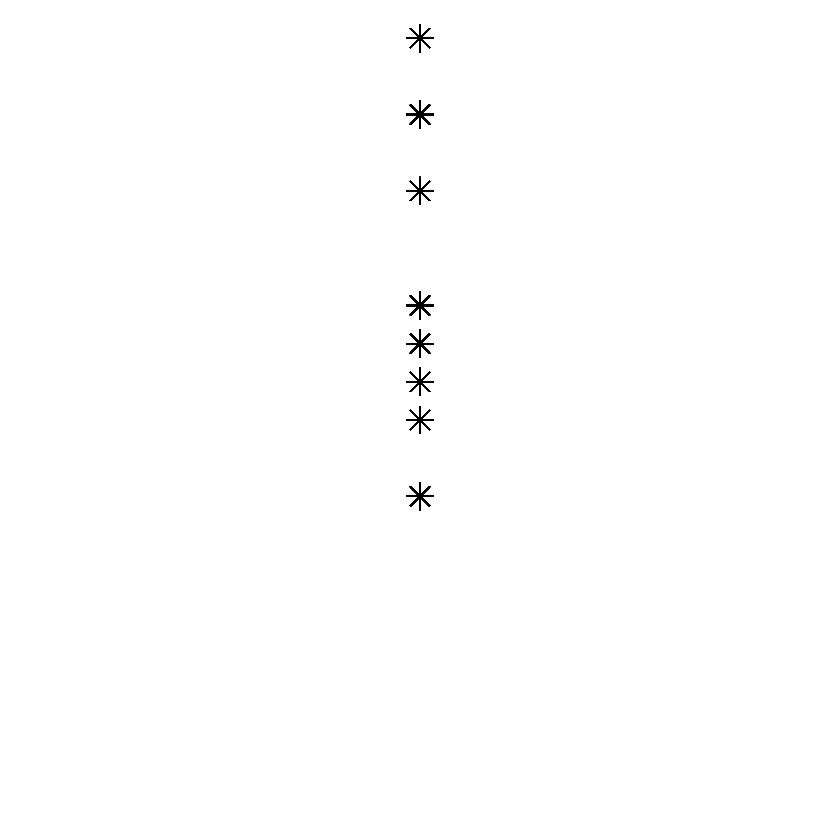

In [46]:
verdict_plot = ggplot(for_heatmap %>% 
                      dplyr::mutate(color_pt = dplyr::case_when(Verdict == "IncreasedPost2010" ~ "true",
                                                             TRUE ~ "none"))) + 
    geom_point(aes(y = y, x = 0, color = color_pt),pch=8,size=5) + theme_void(base_size=16) + 
    xlim(-0.5,0.5) + 
    scale_color_manual(breaks=c("true","none"), values = c("black","transparent")) + 
    theme(legend.position="none") + 
    aplot::ylim2(metazoan_tree)
verdict_plot

`summarise()`
has grouped
output by
'Label',
'Year',
'Season'. You
can override
using the
`.groups`
argument.
Warning message:
“The following
aesthetics were
dropped during
statistical
transformation:
x
ℹ This can
  happen when
  ggplot fails
  to infer the
  correct
  grouping
  structure in
  the data.
ℹ Did you
  forget to
  specify a
  `group`
  aesthetic or
  to convert a
  numerical
  variable into
  a factor?”
Warning message:
“The following
aesthetics were
dropped during
statistical
transformation:
x
ℹ This can
  happen when
  ggplot fails
  to infer the
  correct
  grouping
  structure in
  the data.
ℹ Did you
  forget to
  specify a
  `group`
  aesthetic or
  to convert a
  numerical
  variable into
  a factor?”
Warning message:
“Using the
`size`
aesthetic with
geom_segment
was deprecated
in ggplot2
3.4.0.
ℹ Please use
  the
  `linewidth`
  aesthetic
  instead.”
Warning message:
“Using the
`size`
aesthetic with
geom_polygon
was deprecated
in ggplot2
3.4.0.
ℹ Please use
  the


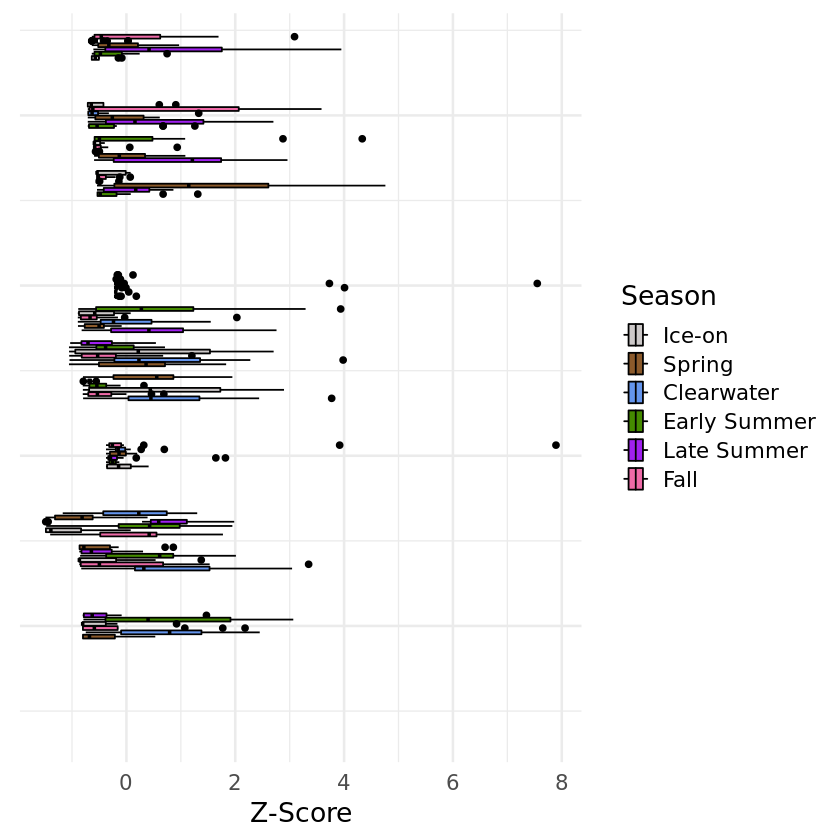

In [28]:
#'Spring''LateSummer''EarlySummer''Ice''Fall''Clearwater'

boxplot_plot = ggplot(for_heatmap %>% dplyr::group_by(Label,Year,Season,y) %>%
     dplyr::summarize(TPM = mean(TPM, na.rm = TRUE)) %>%
     dplyr::filter(!is.na(Season) & !is.na(Year)) %>%
     dplyr::group_by(Label,y) %>% dplyr::mutate(ZScore = (TPM - mean(TPM,na.rm=TRUE))/sd(TPM,na.rm=TRUE))) + 
    geom_boxploth(aes(x = ZScore, y = y, group = factor(paste0(Season,y),
                                                        unique(paste0(c('Spring','LateSummer',
                                                                        'EarlySummer','Ice','Fall','Clearwater'),
                                                                                       y))), 
                      fill = factor(Season,levels=c('Spring','LateSummer','EarlySummer','Ice','Fall','Clearwater'))), 
                  color="black")+theme_minimal(base_size=16) +
    theme(axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank()) +  
    scale_shape_manual(values=c(21,22,23,24),name="Season") + xlab("Z-Score")+ 
    scale_fill_manual(name="Season",
                            breaks = c('Ice','Spring','Clearwater','EarlySummer','LateSummer','Fall'),
                            labels = c("Ice-on","Spring","Clearwater","Early Summer","Late Summer","Fall"),
                            values=c("snow3","tan4","cornflowerblue","chartreuse4","purple","hotpink2"),na.value="black") + 
    aplot::ylim2(metazoan_tree)
boxplot_plot

In [29]:
for_heatmap %>%
    dplyr::mutate(Year = as.numeric(Year)) %>%
    dplyr::arrange(desc(ZScore)) %>% dplyr::select(SampleDate,Year,Season,Label,Verdict,y,TPM,ZScore) %>%
    dplyr::mutate(Invasion=case_when(Year > 2010 ~ "Post",
                                     TRUE ~ "Pre")) %>%
    dplyr::group_by(Label,Invasion,Season,y,Verdict) %>% dplyr::summarize(ZScore = mean(ZScore)) %>%
    tidyr::pivot_wider(id_cols=c("Label","y","Season","Verdict"),names_from="Invasion",values_from="ZScore") %>%
    dplyr::mutate(Ratio = (Post-Pre)/abs(Pre)) %>% 
    dplyr::mutate(Ratio = Post/Pre) %>% 
    dplyr::mutate(Diff = Post-Pre) %>% dplyr::arrange(desc(abs(Ratio))) 


`summarise()`
has grouped
output by
'Label',
'Invasion',
'Season', 'y'.
You can
override using
the `.groups`
argument.


Label,y,Season,Verdict,Post,Pre,Ratio,Diff
<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
MEND-TF-18S-318,19,LateSummer,NA,0.2412665,0.004445093,54.277050,0.23682145
MEND-TF-18S-120,18,Fall,IncreasedPost2010,0.5241263,-0.045285253,-11.573884,0.56941152
MEND-TF-18S-318,19,Clearwater,NA,0.1076691,-0.012503192,-8.611325,0.12017225
MEND-TF-18S-120,18,LateSummer,IncreasedPost2010,0.3292104,-0.042531086,-7.740466,0.37174151
MEND-TF-18S-115,14,Fall,IncreasedPost2010,-0.3351607,0.051186473,-6.547837,-0.38634715
MEND-TF-18S-110,12,LateSummer,IncreasedPost2010,-0.1440999,-0.028724361,5.016643,-0.11537549
MEND-TF-18S-113,13,LateSummer,IncreasedPost2010,-0.3572023,0.079884670,-4.471475,-0.43708700
MEND-TF-18S-23,5,LateSummer,NA,-0.2774944,-0.064597731,4.295729,-0.21289663
MEND-TF-18S-115,14,Clearwater,IncreasedPost2010,0.3881076,-0.099792494,-3.889146,0.48790010


`summarise()`
has grouped
output by
'Label',
'Invasion',
'Season'. You
can override
using the
`.groups`
argument.
Warning message:
“Removed 32 rows
containing
missing values
(`geom_point()`).”


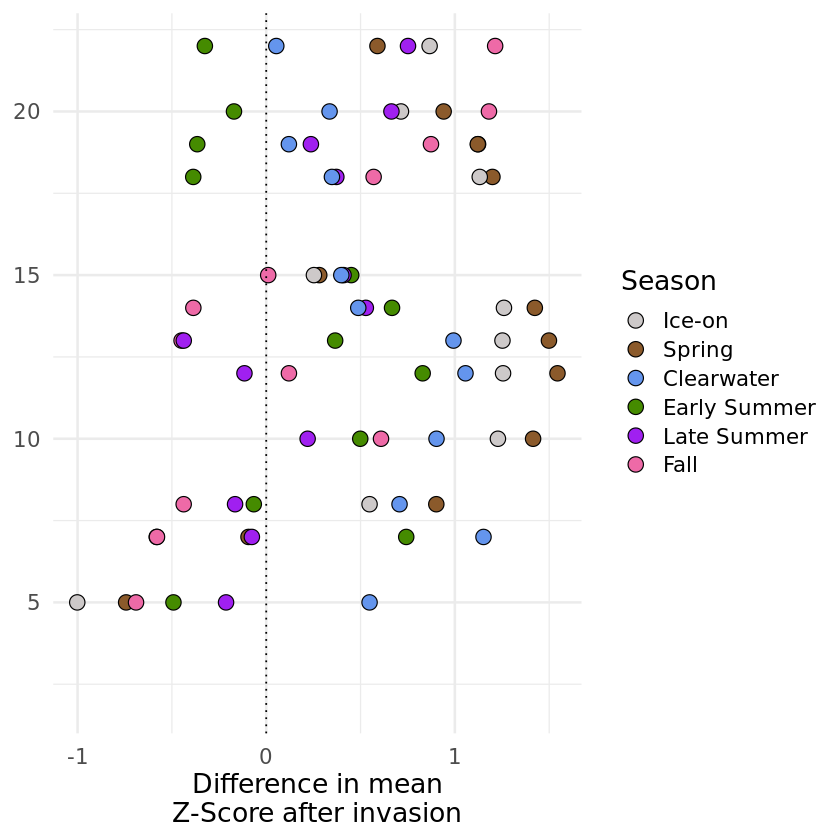

In [30]:
change_plot = ggplot(for_heatmap %>%
    dplyr::mutate(Year = as.numeric(Year)) %>%
    dplyr::arrange(desc(ZScore)) %>% dplyr::select(SampleDate,Year,Season,Label,y,TPM,ZScore) %>%
    dplyr::mutate(Invasion=case_when(Year > 2010 ~ "Post",
                                     TRUE ~ "Pre")) %>%
    dplyr::group_by(Label,Invasion,Season,y) %>% dplyr::summarize(ZScore = mean(ZScore)) %>%
    tidyr::pivot_wider(id_cols=c("Label","y","Season"),names_from="Invasion",values_from="ZScore") %>%
    dplyr::mutate(Ratio = (Post-Pre)/abs(Pre)) %>% 
    dplyr::mutate(Ratio = Post/Pre) %>% 
    dplyr::mutate(Diff = Post-Pre) %>% dplyr::arrange(desc(abs(Diff))) ) +
    geom_point(aes(x = Diff, fill = Season, y = y),pch=21,size=4) + 
    aplot::ylim2(metazoan_tree)+ 
    scale_fill_manual(name="Season",
                            breaks = c('Ice','Spring','Clearwater','EarlySummer','LateSummer','Fall'),
                            labels = c("Ice-on","Spring","Clearwater","Early Summer","Late Summer","Fall"),
                            values=c("snow3","tan4","cornflowerblue","chartreuse4","purple","hotpink2"),na.value="black") +
    theme_minimal(base_size=16)+geom_vline(aes(xintercept=0),linetype="dotted")+
    theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=0.5),
          axis.title.y=element_blank(),
          #axis.text.y=element_blank(),
          axis.ticks.y=element_blank())+xlab("Difference in mean\nZ-Score after invasion")
change_plot


Warning message:
“Removed 32 rows
containing
missing values
(`geom_point()`).”


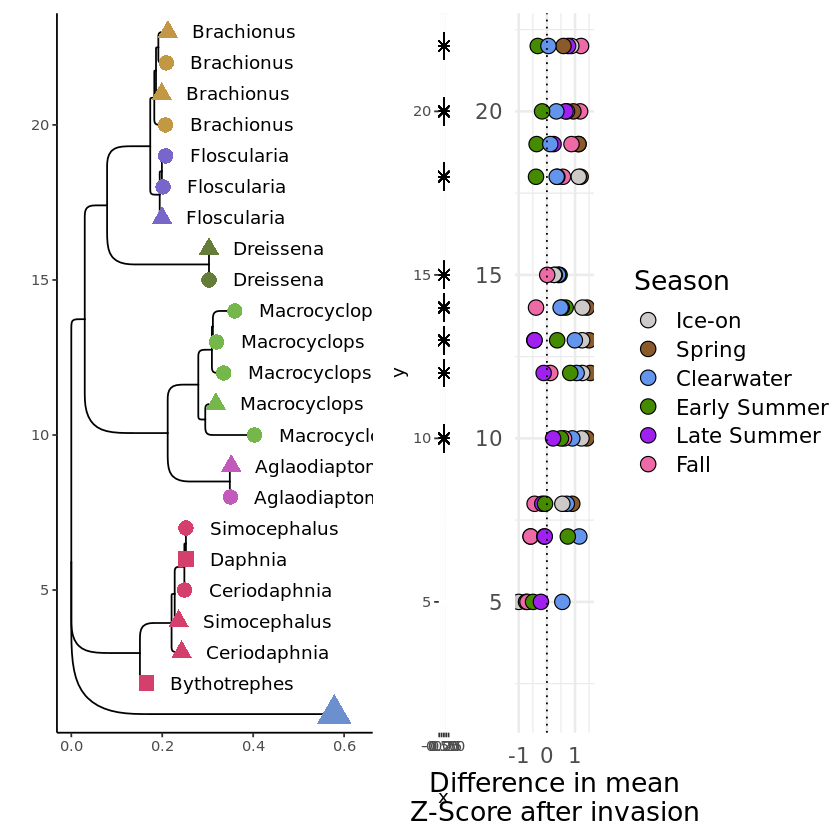

In [45]:
cowplot::plot_grid(metazoan_tree+theme(legend.position="none"),
                   rel_widths=c(1,0.2,1),verdict_plot,change_plot,align="hv",axis="l",ncol=3)

Warning message:
“Removed 32 rows
containing
missing values
(`geom_point()`).”


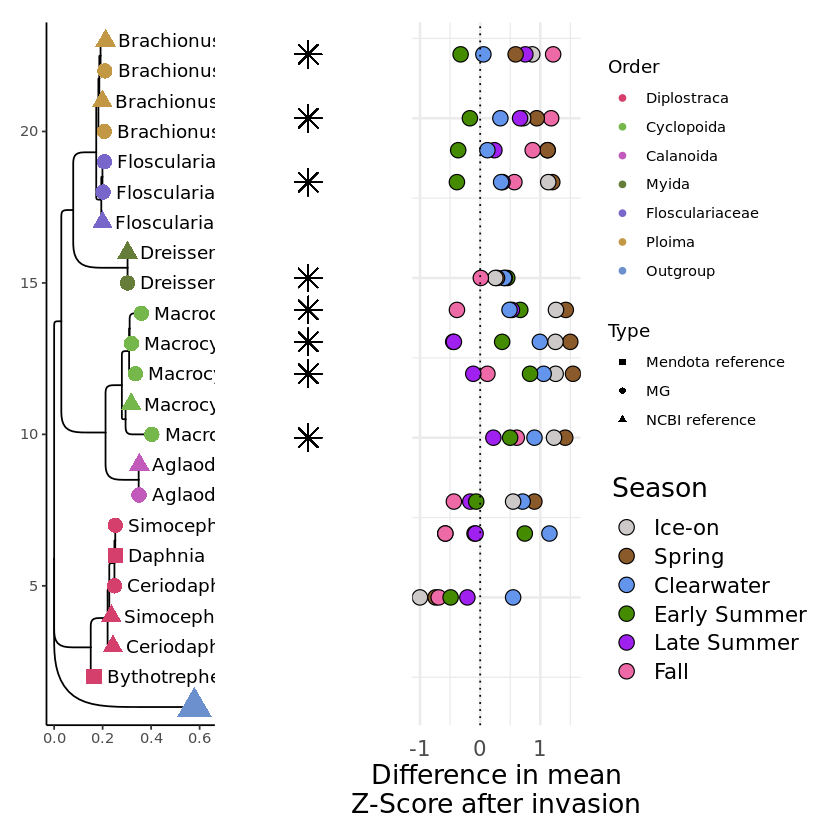

In [48]:
(metazoan_tree|verdict_plot|change_plot+
  theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
        axis.ticks.y=element_blank()))+
 plot_layout(guides = 'collect')

`summarise()` has grouped
output by 'Label', 'Year',
'Season'. You can override
using the `.groups`
argument.


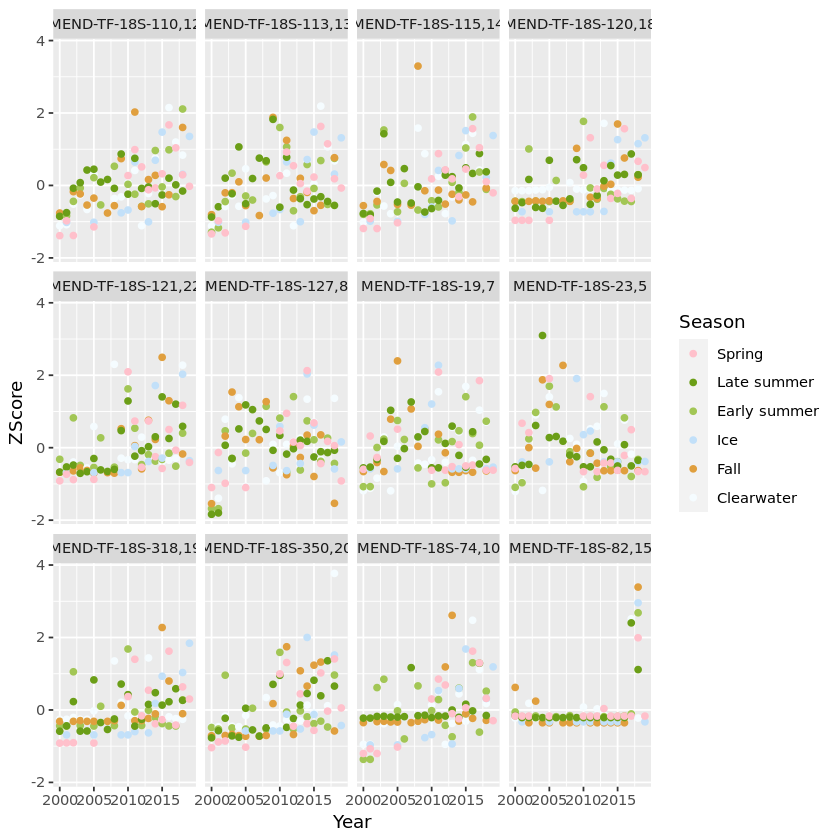

In [103]:
ggplot(for_heatmap %>%
    dplyr::mutate(Year = as.numeric(Year)) %>%
    dplyr::left_join(means_with_seasons_,by=c("Season","Label")) %>%
    dplyr::group_by(Label,y) %>%
    dplyr::mutate(ZScore = (TPM - meanTPM) / sdTPM) %>%
    dplyr::arrange(desc(ZScore)) %>% dplyr::select(SampleDate,Year,Season,Label,y,TPM, meanTPM,sdTPM,ZScore) %>%
    dplyr::group_by(Label,Year,Season,y) %>% dplyr::summarize(ZScore = mean(ZScore)) %>%
    dplyr::filter(!is.na(Label))) + 
    geom_point(aes(x = Year, y = ZScore,col=Season)) + 
    scale_color_manual(name="Season",
                            breaks = c('Spring','LateSummer','EarlySummer','Ice','Fall','Clearwater'),
                            labels = c('Spring','Late summer','Early summer','Ice','Fall','Clearwater'),
                            values=c("pink","#6B9E17","#A2C655","#c2e0f9","#e09f3e","#f5fcff"),na.value="black")+ 
    facet_wrap(~paste0(Label,",",y))#facet_grid(cols=vars(Season),rows=vars(Label))



In [50]:
for_heatmap

parent,node,branch.length,label,isTip,x,y,branch,angle,X,⋯,NewLab,NewLabGenus,NewSize,Season,SampleDate,TPM,Year,Label,ZScore,Verdict
<int>,<int>,<dbl>,<chr>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
29,1,0.0000019664,k141_802811SSU_rRNA_eukarya_DAPHNIA_PULICARIA,TRUE,0.2520903,6,0.2520893,93.91304,NA,⋯,Diplostraca,Daphnia,,NA,NA,NA,NA,NA,NA,NA
25,2,0.0140011915,k141_558785SSU_rRNA_eukarya_SPINY_WATER_FLEA,TRUE,0.1649206,2,0.1579200,31.30435,NA,⋯,Diplostraca,Bythotrephes,,NA,NA,NA,NA,NA,NA,NA
33,3,0.1084278273,Ga0335021_0014896SSU_rRNA_eukarya,TRUE,0.4030305,10,0.3488166,156.52174,NA,⋯,Cyclopoida,Macrocyclops,,Spring,16May2013,699.1342,2013,MEND-TF-18S-74,-0.25590791,IncreasedPost2010
33,3,0.1084278273,Ga0335021_0014896SSU_rRNA_eukarya,TRUE,0.4030305,10,0.3488166,156.52174,NA,⋯,Cyclopoida,Macrocyclops,,LateSummer,13Sep2014,210.4212,2014,MEND-TF-18S-74,-0.18562387,IncreasedPost2010
33,3,0.1084278273,Ga0335021_0014896SSU_rRNA_eukarya,TRUE,0.4030305,10,0.3488166,156.52174,NA,⋯,Cyclopoida,Macrocyclops,,EarlySummer,04Jul2014,1030.4286,2014,MEND-TF-18S-74,1.71134576,IncreasedPost2010
33,3,0.1084278273,Ga0335021_0014896SSU_rRNA_eukarya,TRUE,0.4030305,10,0.3488166,156.52174,NA,⋯,Cyclopoida,Macrocyclops,,LateSummer,18Aug2017,546.4861,2017,MEND-TF-18S-74,-0.12188170,IncreasedPost2010
33,3,0.1084278273,Ga0335021_0014896SSU_rRNA_eukarya,TRUE,0.4030305,10,0.3488166,156.52174,NA,⋯,Cyclopoida,Macrocyclops,,LateSummer,02Sep2004,156.1599,2004,MEND-TF-18S-74,-0.19591572,IncreasedPost2010
33,3,0.1084278273,Ga0335021_0014896SSU_rRNA_eukarya,TRUE,0.4030305,10,0.3488166,156.52174,NA,⋯,Cyclopoida,Macrocyclops,,LateSummer,18Aug2006,0.0000,2006,MEND-TF-18S-74,-0.22553492,IncreasedPost2010
33,3,0.1084278273,Ga0335021_0014896SSU_rRNA_eukarya,TRUE,0.4030305,10,0.3488166,156.52174,NA,⋯,Cyclopoida,Macrocyclops,,Ice,13Mar2001,0.0000,2001,MEND-TF-18S-74,-0.96354427,IncreasedPost2010


Adding missing
grouping
variables:
`NewLabGenus`
`summarise()`
has grouped
output by
'Label',
'NewLabGenus',
'Year',
'Verdict',
'Season'. You
can override
using the
`.groups`
argument.


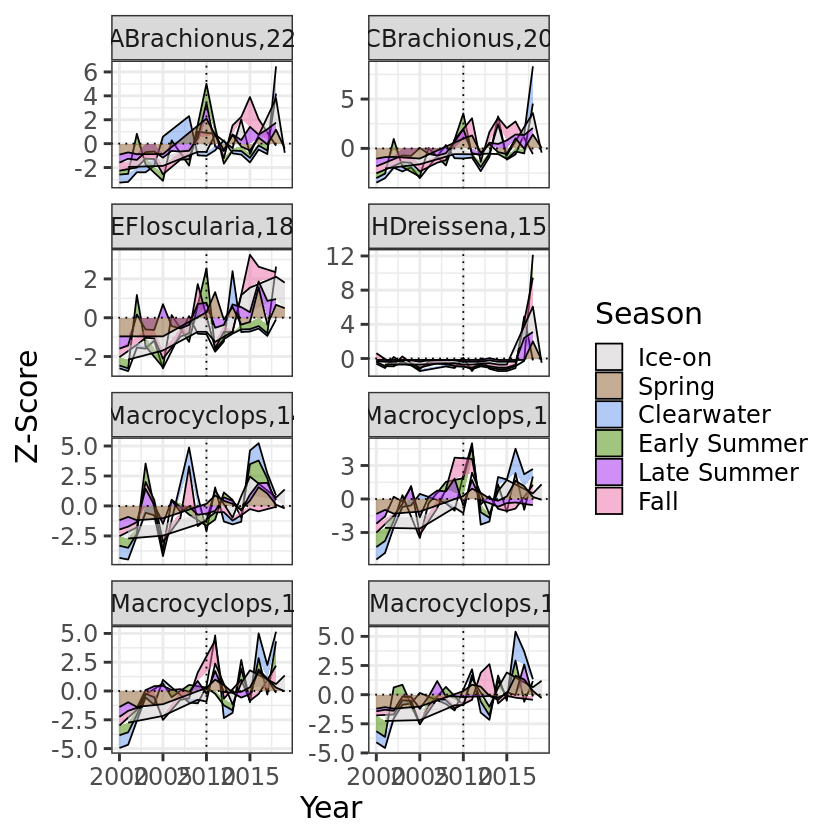

In [60]:
stacked_line_plot = ggplot(for_heatmap %>%dplyr::filter(Verdict=="IncreasedPost2010") %>%
    dplyr::mutate(Year = as.numeric(Year)) %>%
    dplyr::left_join(means_with_seasons_,by=c("Season","Label")) %>%
    dplyr::group_by(Label,NewLabGenus,y,Verdict) %>%
    dplyr::mutate(ZScore = (TPM - meanTPM) / sdTPM) %>%
    dplyr::arrange(desc(ZScore)) %>% dplyr::select(SampleDate,Year,Verdict,Season,Label,y,TPM, meanTPM,sdTPM,ZScore) %>%
    dplyr::group_by(Label,NewLabGenus,Year,Verdict,Season,y) %>% dplyr::summarize(ZScore = mean(ZScore)) %>%
    dplyr::filter(!is.na(Label)) %>% dplyr::filter(Verdict=="IncreasedPost2010")) + 
    geom_area(aes(x = Year, y = ZScore,fill=Season,group=Season),stat="identity",position="stack",
                 alpha=0.5,color="black") + 
    scale_fill_manual(name="Season",
                            breaks = c('Ice','Spring','Clearwater','EarlySummer','LateSummer','Fall'),
                            labels = c("Ice-on","Spring","Clearwater","Early Summer","Late Summer","Fall"),
                            values=c("snow3","tan4","cornflowerblue","chartreuse4","purple","hotpink2"),na.value="black")+ 
    facet_wrap(~paste0(LETTERS[23-y],NewLabGenus,",",y),ncol=2,scales="free_y") + 
    geom_vline(aes(xintercept=2010),linetype="dotted") + theme_bw(base_size=18)+ 
    geom_hline(aes(yintercept=0),linetype="dotted")+ylab("Z-Score")

stacked_line_plot


In [13]:
#'Spring''LateSummer''EarlySummer''Ice''Fall''Clearwater'

heatmap_plot_seasons = ggplot(for_heatmap %>%
    dplyr::mutate(Year = as.numeric(Year)) %>%
    dplyr::left_join(means_with_seasons_,by=c("Season","Label")) %>%
    dplyr::group_by(Label,y) %>%
    dplyr::mutate(ZScore = (TPM - meanTPM) / sdTPM) %>%
    dplyr::arrange(desc(ZScore)) %>% dplyr::select(SampleDate,Year,Season,Label,y,TPM, meanTPM,sdTPM,ZScore) %>%
    dplyr::group_by(Label,Year,Season,y) %>% dplyr::summarize(ZScore = mean(ZScore))) + 
    geom_boxploth(aes(x = ZScore, y = y, group = factor(paste0(Season,y),
                                                        unique(paste0(c('Spring','LateSummer',
                                                                        'EarlySummer','Ice','Fall','Clearwater'),
                                                                                       y))), 
                      fill = factor(Season,levels=c('Spring','LateSummer','EarlySummer','Ice','Fall','Clearwater')),
                      color = factor(Season,levels=c('Spring','LateSummer','EarlySummer','Ice','Fall','Clearwater'))))+theme_minimal(base_size=16) +
    theme(axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank()) +  
    scale_shape_manual(values=c(21,22,23,24),name="Season") + xlab("Z-Score") + 
    scale_fill_manual(name="Season",
                            breaks = c('Ice','Spring','Clearwater','EarlySummer','LateSummer','Fall'),
                            labels = c("Ice-on","Spring","Clearwater","Early Summer","Late Summer","Fall"),
                            values=c("snow3","tan4","cornflowerblue","chartreuse4","purple","hotpink2"),na.value="black") + 
    scale_color_manual(name="Season",
                            breaks = c('Ice','Spring','Clearwater','EarlySummer','LateSummer','Fall'),
                            labels = c("Ice-on","Spring","Clearwater","Early Summer","Late Summer","Fall"),
                            values=c("snow3","tan4","cornflowerblue","chartreuse4","purple","hotpink2"),na.value="black") + 
    aplot::ylim2(metazoan_tree)
heatmap_plot_seasons

ERROR: Error in dplyr::mutate(., Year = as.numeric(Year)): object 'for_heatmap' not found


`summarise()` has grouped
output by 'Label', 'Year',
'Season'. You can override
using the `.groups`
argument.


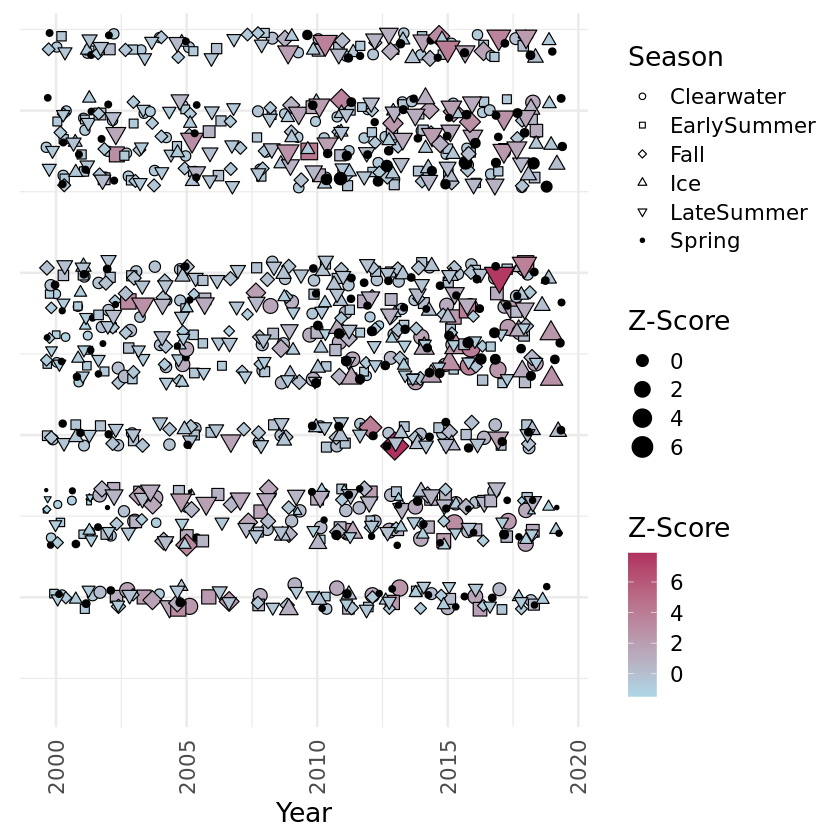

In [106]:
library(aplot)
heatmap_plot = ggplot(for_heatmap %>% dplyr::group_by(Label,Year,Season,y) %>%
     dplyr::summarize(TPM = mean(TPM, na.rm = TRUE)) %>%
     dplyr::filter(!is.na(Season) & !is.na(Year)) %>%
     dplyr::group_by(Label,y) %>% dplyr::mutate(ZScore = (TPM - mean(TPM,na.rm=TRUE))/sd(TPM,na.rm=TRUE))) + 
    geom_jitter(aes(x = as.numeric(Year), y = y, size = ZScore, fill = ZScore,
                   shape = factor(Season)),color="black")+
    scale_size(name="Z-Score") + 
    scale_fill_gradient(low="light blue", high = "maroon",name="Z-Score") + theme_minimal(base_size=16) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
          axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank()) +  
    scale_shape_manual(values=c(21,22,23,24,25,20),name="Season") + xlab("Year")+ ylim2(metazoan_tree)

heatmap_plot

`summarise()` has grouped
output by 'Label', 'Year',
'Season'. You can override
using the `.groups`
argument.
ERROR while rich displaying an object: Error in `f()`:
! Insufficient values in manual scale. 6 needed but only 4 provided.

Traceback:
1. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
2. tryCatchList(expr, classes, parentenv, handlers)
3. tryCatchOne(expr, names, parentenv, handlers[[1L]])
4. doTryCatch(return(expr), name, parentenv, handler)
5. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_c

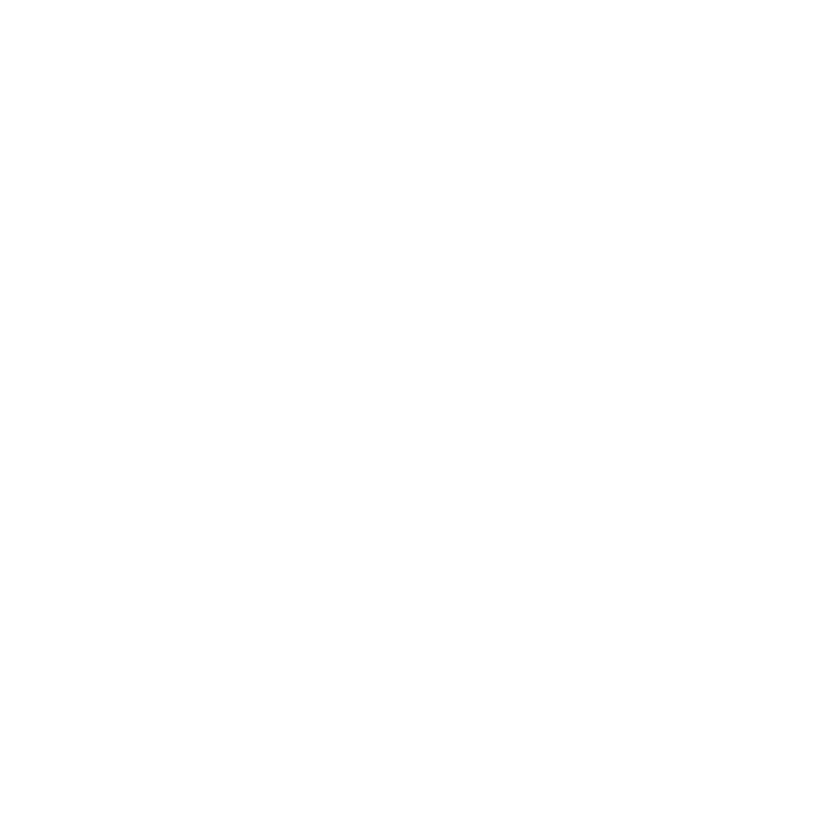

In [107]:
library(aplot)
heatmap_plot = ggplot(for_heatmap %>% dplyr::group_by(Label,Year,Season,y) %>%
     dplyr::summarize(TPM = mean(TPM, na.rm = TRUE)) %>%
     dplyr::filter(!is.na(Season) & !is.na(Year)) %>%
     dplyr::group_by(Label,y) %>% dplyr::mutate(ZScore = (TPM - mean(TPM,na.rm=TRUE))/sd(TPM,na.rm=TRUE))) + 
    geom_jitter(aes(x = as.numeric(Year), y = y, size = ZScore, fill = ZScore,
                   shape = factor(Season)),color="black")+
    scale_size(name="Z-Score") + 
    scale_fill_gradient(low="light blue", high = "maroon",name="Z-Score") + theme_minimal(base_size=16) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
          axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank()) +  
    scale_shape_manual(values=c(21,22,23,24),name="Season") + xlab("Year")+ ylim2(metazoan_tree)

heatmap_plot

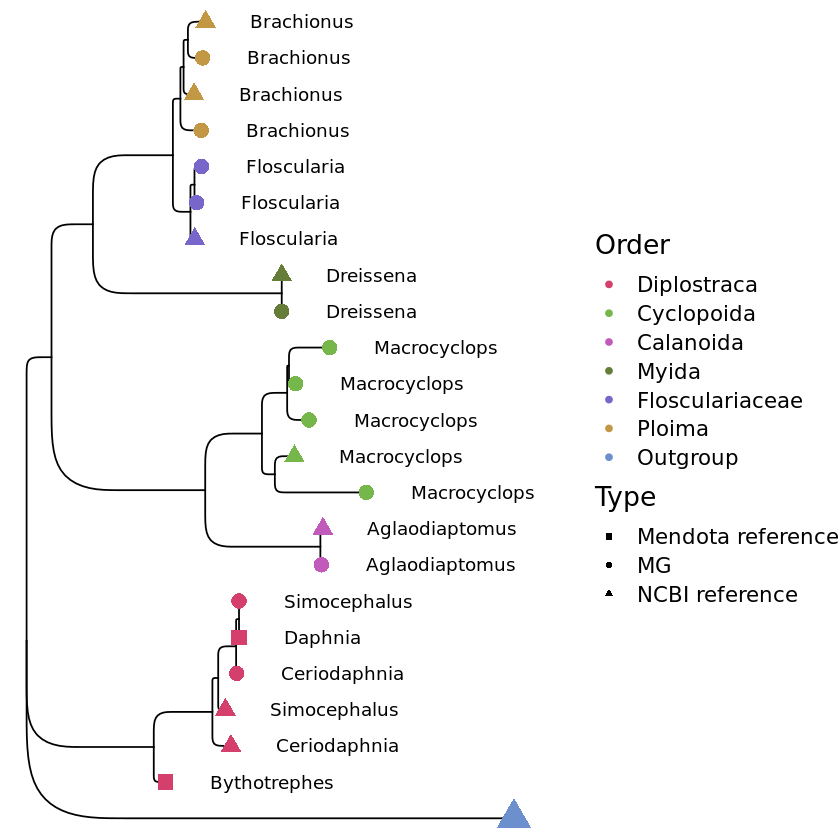

In [24]:
distinct_cols = c("#9f4764", "#58cb5f", "#be54c4", "#4fa433", "#7166d9", "#b0bf2e", "#8b57a1", 
                  "#92bc43", "#d24790", "#55bd81", "#d23d55", "#51c6c0", "#d24b29", "#60a2d7", 
                  "#de882f", "#6077c3", "#d0b13d", "#d08dce", "#417d23", "#e07f89", "#408147", 
                  "#e98060", "#338b70", "#a35630", "#77902d", "#d4a268", "#636f2d", "#9fb56c", 
                  "#86672d", "#9d8527", "black")
distinct_cols = c("#d4406b","#76b74b","#c25abc","#657d39","#7966ca",
                  "#c39844","#6c8fce","#c8603e","#4db598","#bd6a8e")
metazoan_tree = (ggtree(data_frame_metazoan,layout="roundrect") + 
    geom_tippoint(aes(col=NewLab,shape=Type,size=NewSize)) + 
    scale_color_manual(values=distinct_cols, name="Order", 
                       breaks = c(unique(data_frame_metazoan$NewLab),""),
                       labels = c(unique(data_frame_metazoan$NewLab),"Outgroup"),
                      na.value="transparent", na.translate = F) + 
    geom_tiplab(aes(label=NewLabGenus), offset=0.05) +  
    scale_shape_manual(values=c(15,16,17))+
    scale_size_manual(values=c(4,7))+ guides(size="none") +
    theme_void(base_size=16))#+ ylim2(heatmap_plot))
                 
metazoan_tree

In [117]:
spiny_abund_frame %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))) %>%
       dplyr::mutate(FormattedDate=as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")) %>%
       dplyr::full_join(seasonal_info,by=c("Year")) %>%
       dplyr::filter((FormattedDate >= StartDate) & (FormattedDate <= EndDate))%>%
       dplyr::mutate(MAGName = dplyr::case_when(grepl("KMAS001",MAG) ~ "Daphnia pulicaria",
                                                grepl("KMAS002",MAG) ~ "Bythotrephes longimanus"),
                     Order = "Diplostraca")

V1,SeqProjID,MAG,TotalReads,TPM,X,AnalysisIDs,SeqIDs,Assembly,Raw,⋯,Analysis.Project.ITS.Analysis.Project.ID,SampleDate,Month,Year,FormattedDate,Season,StartDate,EndDate,MAGName,Order
<int>,<int>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<chr>,<chr>,⋯,<int>,<chr>,<dbl>,<dbl>,<date>,<chr>,<date>,<date>,<chr>,<chr>
0,1229872,KMAS002_S16_L004_eukbin-Copy1-1,102614849,1653.721843,39,1229697,1229872,/global/dna/dm_archive/img/submissions/209661/Ga0334983_contigs.fna,/global/dna/dm_archive/rqc/analyses/AUTO-226251/12844.1.289902.CCAGTGTT-AACACTGG.filter-METAGENOME.fastq.gz,⋯,1229697,16May2013,5,2013,2013-05-16,Spring,2013-04-11,2013-05-18,Bythotrephes longimanus,Diplostraca
1,1229873,KMAS002_S16_L004_eukbin-Copy1-1,78275406,432.329032,67,1229699,1229873,/global/dna/dm_archive/img/submissions/209662/Ga0334984_contigs.fna,/global/dna/dm_archive/rqc/analyses/AUTO-226252/12844.1.289902.TGTACACC-GGTGTACA.filter-METAGENOME.fastq.gz,⋯,1229699,13Sep2014,9,2014,2014-09-13,LateSummer,2014-07-14,2014-10-11,Bythotrephes longimanus,Diplostraca
2,1229874,KMAS002_S16_L004_eukbin-Copy1-1,110407856,1274.989535,311,1229701,1229874,/global/dna/dm_archive/img/submissions/209663/Ga0334985_contigs.fna,/global/dna/dm_archive/rqc/analyses/AUTO-226253/12844.1.289902.TCGCTGTT-AACAGCGA.filter-METAGENOME.fastq.gz,⋯,1229701,04Jul2014,7,2014,2014-07-04,EarlySummer,2014-06-14,2014-07-13,Bythotrephes longimanus,Diplostraca
3,1229875,KMAS002_S16_L004_eukbin-Copy1-1,67199371,600.442990,163,1229703,1229875,/global/dna/dm_archive/img/submissions/209664/Ga0334986_contigs.fna,/global/dna/dm_archive/rqc/analyses/AUTO-226258/12844.1.289902.AGCTAACC-GGTTAGCT.filter-METAGENOME.fastq.gz,⋯,1229703,18Aug2017,8,2017,2017-08-18,LateSummer,2017-07-08,2017-10-20,Bythotrephes longimanus,Diplostraca
4,1229876,KMAS002_S16_L004_eukbin-Copy1-1,106608420,1065.017021,18,1229705,1229876,/global/dna/dm_archive/img/submissions/209665/Ga0334987_contigs.fna,/global/dna/dm_archive/rqc/analyses/AUTO-226259/12844.1.289902.GGACTGTT-AACAGTCC.filter-METAGENOME.fastq.gz,⋯,1229705,02Sep2004,9,2004,2004-09-02,LateSummer,2004-07-21,2004-10-05,Bythotrephes longimanus,Diplostraca
5,1229877,KMAS002_S16_L004_eukbin-Copy1-1,99375421,152.188073,103,1229707,1229877,/global/dna/dm_archive/img/submissions/209666/Ga0334988_contigs.fna,/global/dna/dm_archive/rqc/analyses/AUTO-226260/12844.1.289902.ACGGAACA-TGTTCCGT.filter-METAGENOME.fastq.gz,⋯,1229707,18Aug2006,8,2006,2006-08-18,LateSummer,2006-07-21,2006-10-08,Bythotrephes longimanus,Diplostraca
6,1229878,KMAS002_S16_L004_eukbin-Copy1-1,101057810,8.244859,249,1229709,1229878,/global/dna/dm_archive/img/submissions/209667/Ga0334989_contigs.fna,/global/dna/dm_archive/rqc/analyses/AUTO-226261/12844.1.289902.GTTCGGTT-AACCGAAC.filter-METAGENOME.fastq.gz,⋯,1229709,13Mar2001,3,2001,2001-03-13,Ice,2001-01-01,2001-04-06,Bythotrephes longimanus,Diplostraca
7,1229879,KMAS002_S16_L004_eukbin-Copy1-1,66659537,3048.503961,50,1229711,1229879,/global/dna/dm_archive/img/submissions/209668/Ga0334990_contigs.fna,/global/dna/dm_archive/rqc/analyses/AUTO-226262/12844.1.289902.ACAGCAAC-GTTGCTGT.filter-METAGENOME.fastq.gz,⋯,1229711,13Apr2016,4,2016,2016-04-13,Spring,2016-03-13,2016-05-02,Bythotrephes longimanus,Diplostraca
8,1229880,KMAS002_S16_L004_eukbin-Copy1-1,75189466,1385.477787,193,1229713,1229880,/global/dna/dm_archive/img/submissions/209669/Ga0334991_contigs.fna,/global/dna/dm_archive/rqc/analyses/AUTO-226263/12844.1.289902.CGTAGGTT-AACCTACG.filter-METAGENOME.fastq.gz,⋯,1229713,07Jun2018,6,2018,2018-06-07,EarlySummer,2018-06-02,2018-07-03,Bythotrephes longimanus,Diplostraca


Warning message in dplyr::full_join(., seasonal_info, by = c("Year")):
“Detected an
unexpected
many-to-many
relationship
between `x` and
`y`.
ℹ Row 1 of `x`
  matches
  multiple rows
  in `y`.
ℹ Row 98 of `y`
  matches
  multiple rows
  in `x`.
ℹ If a
  many-to-many
  relationship
  is expected,
  set
  `relationship
  =
  "many-to-many"`
  to silence
  this warning.”
Scale for fill
is already
present.
Adding another
scale for fill,
which will
replace the
existing scale.


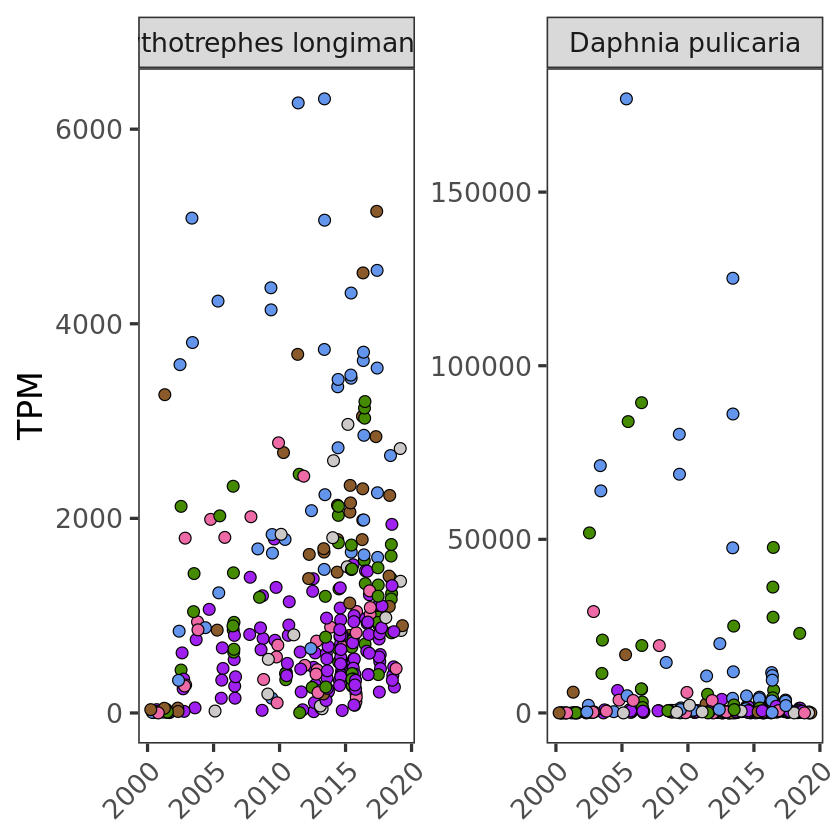

In [62]:
mag_spiny_water = ggplot(spiny_abund_frame %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))) %>%
       dplyr::mutate(FormattedDate=as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")) %>%
       dplyr::full_join(seasonal_info,by=c("Year")) %>%
       dplyr::filter((FormattedDate >= StartDate) & (FormattedDate <= EndDate))%>%
       dplyr::mutate(MAGName = dplyr::case_when(grepl("KMAS001",MAG) ~ "Daphnia pulicaria",
                                                grepl("KMAS002",MAG) ~ "Bythotrephes longimanus"),
                     Order = "Diplostraca")) + 
        geom_point(aes(x = as.Date(SampleDate,format="%d%b%Y"),
                                           y = TPM,fill=Season),size=3,pch=21) + 
    facet_wrap(~MAGName,scales="free_y") + theme_test(base_size=20) +
        theme(axis.title.x=element_blank())+ 
    scale_fill_manual(values=distinct_cols, name="Order", 
                       breaks = c(unique(data_frame_metazoan$NewLab),""),
                       labels = c(unique(data_frame_metazoan$NewLab),"Outgroup"),
                      na.value="transparent", na.translate = F) + 
    scale_fill_manual(name="Season",
                            breaks = c('Ice','Spring','Clearwater','EarlySummer','LateSummer','Fall'),
                            labels = c("Ice-on","Spring","Clearwater","Early Summer","Late Summer","Fall"),
                            values=c("snow3","tan4","cornflowerblue","chartreuse4","purple","hotpink2"),na.value="black")+ 
    theme(legend.position="none")+
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))
mag_spiny_water

Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”


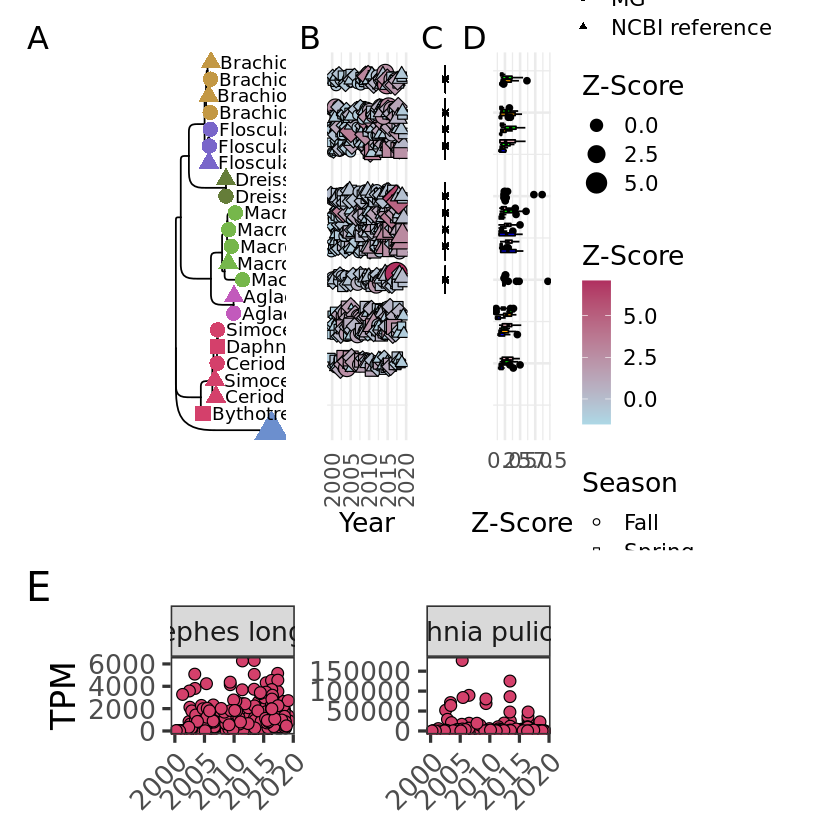

In [64]:
((metazoan_tree | heatmap_plot | verdict_plot | boxplot_plot)+
 plot_layout(guides = 'collect',widths=c(2,1.4,0.1,1)))/ (mag_spiny_water)+ 
    plot_layout(guides = 'collect',widths=c(2,1.4,0.1,1),heights=c(1,0.2)) + plot_annotation(tag_levels = 'A')
ggsave("../../figures/metazoan_facetted_plot.png",dpi=400,width=12,height=12,units="in")
ggsave("../../figures/metazoan_facetted_plot.pdf",dpi=400,width=12,height=12,units="in")

Warning message:
“Removed 32 rows
containing
missing values
(`geom_point()`).”
Warning message:
“Removed 32 rows
containing
missing values
(`geom_point()`).”
Warning message:
“Removed 32 rows
containing
missing values
(`geom_point()`).”


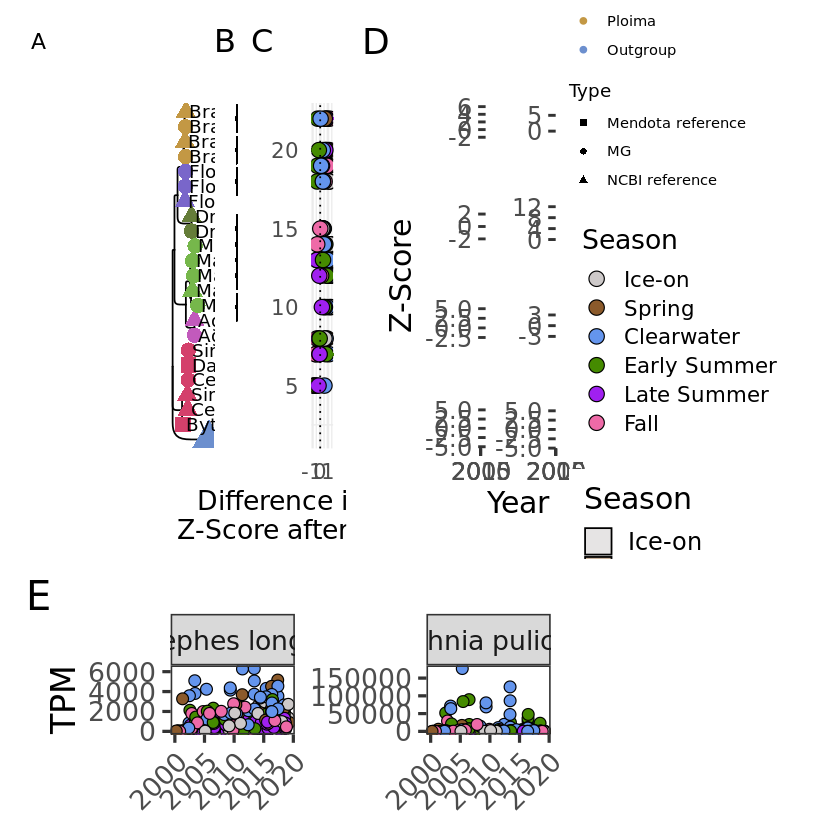

In [65]:
((metazoan_tree+theme_void() | verdict_plot | change_plot | stacked_line_plot)+
 plot_layout(guides = 'collect',widths=c(2,0.1,1,3)))/ (mag_spiny_water)+ 
    plot_layout(guides = 'collect',widths=c(2,1.4,0.1,1),heights=c(1,0.2)) + plot_annotation(tag_levels = 'A')
ggsave("../../figures/metazoan_facetted_plot_rev_2.png",dpi=400,width=17,height=12,units="in")
ggsave("../../figures/metazoan_facetted_plot_rev_2.pdf",dpi=400,width=17,height=12,units="in")